In [53]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import warnings
from tqdm import tqdm_notebook as tqdm
import requests
import json
import API
import matplotlib.pyplot as plt
import GoogleDistanceMatrix
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [54]:
!pwd

/home/mingyi/Dropbox/2020fall/RiderSharing/code


In [55]:
order = pd.read_excel('../1. Sales Data/DMS order_2-6Nov2020 (Only store with DMS available)+Transportation.xlsx')
store = pd.read_csv('Data/StoreLocation.csv')

In [56]:
order.columns

Index(['日期', '門店名稱', '配送地址', '下單時間', '指派成功時間', '騎手接單時間', '到店取餐時間', '取餐出發時間',
       '訂單送達時間', '預送達時間', 'Banner', 'Instant Order', '收貨地址坐標', 'Rider',
       'Transportation'],
      dtype='object')

In [57]:
order = order.merge(store, how='left',left_on='門店名稱', right_on='storeCode')

In [58]:
order['orderTime'] = pd.to_datetime(order['下單時間'])

order['orderDate'] = pd.to_datetime(order['下單時間']).dt.day

order['departureTime'] = pd.to_datetime(order['取餐出發時間'])
order['hour'] = order['departureTime'].dt.hour
order['min'] = order['departureTime'].dt.minute

order = order.sort_values(by=['orderTime'])


In [59]:
order = order.loc[order.orderDate==6]
order = order.loc[order['門店名稱'].isin(['PHD606','PH64'])]
order = order.loc[order['Instant Order']==True]

In [60]:
rider = pd.read_excel('../1. Sales Data/2-6Nov - Clock in record.xls')
rider['Clock in.1'] = pd.to_datetime(rider['Clock in.1'])
rider['Date'] = rider['Clock in.1'].dt.day

In [61]:
rider['Rider Store Code'].unique()

array([ 57, 629,  64, 606])

In [62]:
len(rider.loc[(rider['Rider Store Code'].isin([64,606]))&(rider['Date']==6)]['Rider No.'].unique())

7

In [63]:
len(rider.loc[(rider['Rider Store Code'].isin([57,629]))&(rider['Date']==6)]['Rider No.'].unique())

11

In [66]:
order['min'] = order['min'].apply(lambda x: int(x/5)*5)

In [67]:
order

,日期,門店名稱,配送地址,下單時間,指派成功時間,騎手接單時間,到店取餐時間,取餐出發時間,訂單送達時間,預送達時間,Banner,Instant Order,收貨地址坐標,Rider,Transportation,storeCode,lat,lon,orderTime,orderDate,departureTime,hour,min
578,2020-11-06,PHD606,半山 般咸道 62 號 怡基閣 9 樓 A 室,2020-11-06 11:14:00,2020-11-06 11:14:32,2020-11-06 11:14:32,2020-11-06 11:14:41,2020-11-06 11:24:23,2020-11-06 11:37:42,2020-11-06 11:52:26,PHD,True,"22.281393726854336,114.14871787850188",Mike,rider,PHD606,22.284362,114.139793,2020-11-06 11:14:00,6,2020-11-06 11:24:23,11,0
544,2020-11-06,PH64,西環 皇后大道西 134 號 西營盤賽馬會分科診療所 3樓牙 座 3樓牙 樓 3樓牙 ...,2020-11-06 11:26:00,2020-11-06 11:32:44,2020-11-06 11:32:44,2020-11-06 11:32:53,2020-11-06 11:33:31,2020-11-06 11:49:43,2020-11-06 12:02:32,PHHK,True,"22.283639469805014,114.15016594901385",Tak,rider,PH64,22.284393,114.141973,2020-11-06 11:26:00,6,2020-11-06 11:33:31,11,5
580,2020-11-06,PHD606,灣仔 灣仔道 1 號 壹環,2020-11-06 11:29:00,2020-11-06 11:38:02,2020-11-06 11:38:02,2020-11-06 11:45:33,2020-11-06 11:49:06,2020-11-06 12:25:21,2020-11-06 12:07:42,PHD,True,"22.271920156656726,114.17925116574305",Mike,rider,PHD606,22.284362,114.139793,2020-11-06 11:29:00,6,2020-11-06 11:49:06,11,5
593,2020-11-06,PHD606,西環 德輔道西 418 號 太平洋廣場 6 樓 6015 單位 6015 室,2020-11-06 11:30:00,2020-11-06 12:02:16,2020-11-06 12:02:31,2020-11-06 12:04:50,2020-11-06 12:04:59,2020-11-06 12:23:42,2020-11-06 12:10:12,PHD,True,NaN,3rdParty,3rdParty,PHD606,22.284362,114.139793,2020-11-06 11:30:00,6,2020-11-06 12:04:59,12,0
599,2020-11-06,PHD606,西環 龍華街 9 號 香港大學賽馬會第三學生村 香港大學信興學院,2020-11-06 11:33:00,2020-11-06 12:02:20,2020-11-06 12:05:19,2020-11-06 12:23:26,2020-11-06 12:24:01,2020-11-06 12:34:10,2020-11-06 12:12:08,PHD,True,NaN,3rdParty,3rdParty,PHD606,22.284362,114.139793,2020-11-06 11:33:00,6,2020-11-06 12:24:01,12,0
558,2020-11-06,PHD606,上環 干諾道中 110-114 號 永安中心 13 樓 1308 單位 1308 室,2020-11-06 11:50:00,2020-11-06 11:52:02,2020-11-06 11:52:02,2020-11-06 11:52:15,2020-11-06 11:52:22,2020-11-06 12:24:24,2020-11-06 12:35:14,PHD,True,"22.28392231035785,114.15796742160667",Hang,rider,PHD606,22.284362,114.139793,2020-11-06 11:50:00,6,2020-11-06 11:52:22,11,10
571,2020-11-06,PHD606,半山 波老道 10 號 香港猶太教國際學校 中英 座,2020-11-06 11:52:00,2020-11-06 12:01:07,2020-11-06 12:09:34,2020-11-06 12:32:25,2020-11-06 12:32:43,2020-11-06 12:48:47,2020-11-06 12:35:36,PHD,True,NaN,3rdParty,3rdParty,PHD606,22.284362,114.139793,2020-11-06 11:52:00,6,2020-11-06 12:32:43,12,5
563,2020-11-06,PHD606,中環 紅棉路 8 號 東昌大廈 22 樓 3 單位 3 室,2020-11-06 11:53:00,2020-11-06 12:25:33,2020-11-06 12:25:33,2020-11-06 13:16:58,2020-11-06 13:16:59,2020-11-06 13:22:23,2020-11-06 12:48:18,PHD,True,"22.277150566636717,114.1676309783361",Mike,rider,PHD606,22.284362,114.139793,2020-11-06 11:53:00,6,2020-11-06 13:16:59,13,0
534,2020-11-06,PH64,薄扶林 本部大樓 香港大學本部大樓,2020-11-06 12:27:00,2020-11-06 12:49:15,2020-11-06 12:49:15,2020-11-06 12:49:22,2020-11-06 12:51:59,2020-11-06 13:11:33,2020-11-06 13:12:50,PHHK,True,"22.281394081172472,114.14286739896207",Yip,Walkboy,PH64,22.284393,114.141973,2020-11-06 12:27:00,6,2020-11-06 12:51:59,12,10
585,2020-11-06,PHD606,西環 域多利道 1 號 百年大樓２座 2 座 25 樓 G 單位 G 室,2020-11-06 12:36:00,2020-11-06 13:03:17,2020-11-06 13:03:17,2020-11-06 13:03:25,2020-11-06 13:03:25,2020-11-06 13:30:20,2020-11-06 13:30:18,PHD,True,"22.279073272152292,114.1311003147725",Hang,rider,PHD606,22.284362,114.139793,2020-11-06 12:36:00,6,2020-11-06 13:03:25,13,0


In [23]:
riders = rider.loc[(rider['Rider Store Code'].isin([64,606]))&(rider['Date']==6)]['Rider No.'].unique()

In [17]:
def get_lat_lon(x):
    location = x['配送地址']
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=香港'+location+'&key='+API.key
    data = requests.get(url)
    text = json.loads(data.text)
    if text['results'] == []:
        pass
    else:
        lat = str(text['results'][0]['geometry']['location']['lat'])
        lng = str(text['results'][0]['geometry']['location']['lng'])
        return(lat+','+lng)

In [18]:
order['DeliveryLatLon'] = order.apply(get_lat_lon,axis=1)

In [19]:
order['StoreLatLon'] = order['lat'].astype(str)+','+order['lon'].astype(str)

In [23]:
order.columns

Index(['日期', '門店名稱', '配送地址', '下單時間', '指派成功時間', '騎手接單時間', '到店取餐時間', '取餐出發時間',
       '訂單送達時間', '預送達時間', 'Banner', 'Instant Order', '收貨地址坐標', 'Rider',
       'Transportation', 'storeCode', 'lat', 'lon', 'orderTime', 'orderDate',
       'departureTime', 'hour', 'min', 'DeliveryLatLon', 'StoreLatLon'],
      dtype='object')

In [70]:
order[['日期', '門店名稱', '配送地址', '下單時間', '指派成功時間', '騎手接單時間', '到店取餐時間', '取餐出發時間',
       '訂單送達時間', '預送達時間', 'storeCode', 'lat', 'lon', 'orderTime', 'orderDate',
       'departureTime', 'hour', 'min', 'DeliveryLatLon', 'StoreLatLon']].to_csv('Data/Order_64_606.csv',index=False)

# Modelling

In [142]:
order = pd.read_csv('Data/Order_64_606.csv')

In [143]:
order

,日期,門店名稱,配送地址,下單時間,指派成功時間,騎手接單時間,到店取餐時間,取餐出發時間,訂單送達時間,預送達時間,storeCode,lat,lon,orderTime,orderDate,departureTime,hour,min,DeliveryLatLon,StoreLatLon
0,2020-11-06 00:00:00,PHD606,半山 般咸道 62 號 怡基閣 9 樓 A 室,2020-11-06 11:14:00,2020-11-06 11:14:32,2020-11-06 11:14:32,2020-11-06 11:14:41,2020-11-06 11:24:23,2020-11-06 11:37:42,2020-11-06 11:52:26,PHD606,22.284362,114.139793,2020-11-06 11:14:00,6,2020-11-06 11:24:23,11,20,"22.2841643,114.1434941","22.284361999999998,114.13979259999999"
1,2020-11-06 00:00:00,PH64,西環 皇后大道西 134 號 西營盤賽馬會分科診療所 3樓牙 座 3樓牙 樓 3樓牙 ...,2020-11-06 11:26:00,2020-11-06 11:32:44,2020-11-06 11:32:44,2020-11-06 11:32:53,2020-11-06 11:33:31,2020-11-06 11:49:43,2020-11-06 12:02:32,PH64,22.284393,114.141973,2020-11-06 11:26:00,6,2020-11-06 11:33:31,11,30,"22.2863114,114.1452516","22.284392699999998,114.141973"
2,2020-11-06 00:00:00,PHD606,灣仔 灣仔道 1 號 壹環,2020-11-06 11:29:00,2020-11-06 11:38:02,2020-11-06 11:38:02,2020-11-06 11:45:33,2020-11-06 11:49:06,2020-11-06 12:25:21,2020-11-06 12:07:42,PHD606,22.284362,114.139793,2020-11-06 11:29:00,6,2020-11-06 11:49:06,11,45,"22.2746606,114.1742897","22.284361999999998,114.13979259999999"
3,2020-11-06 00:00:00,PHD606,西環 德輔道西 418 號 太平洋廣場 6 樓 6015 單位 6015 室,2020-11-06 11:30:00,2020-11-06 12:02:16,2020-11-06 12:02:31,2020-11-06 12:04:50,2020-11-06 12:04:59,2020-11-06 12:23:42,2020-11-06 12:10:12,PHD606,22.284362,114.139793,2020-11-06 11:30:00,6,2020-11-06 12:04:59,12,0,"22.2865433,114.1357141","22.284361999999998,114.13979259999999"
4,2020-11-06 00:00:00,PHD606,西環 龍華街 9 號 香港大學賽馬會第三學生村 香港大學信興學院,2020-11-06 11:33:00,2020-11-06 12:02:20,2020-11-06 12:05:19,2020-11-06 12:23:26,2020-11-06 12:24:01,2020-11-06 12:34:10,2020-11-06 12:12:08,PHD606,22.284362,114.139793,2020-11-06 11:33:00,6,2020-11-06 12:24:01,12,20,"22.2788412,114.1288841","22.284361999999998,114.13979259999999"
5,2020-11-06 00:00:00,PHD606,上環 干諾道中 110-114 號 永安中心 13 樓 1308 單位 1308 室,2020-11-06 11:50:00,2020-11-06 11:52:02,2020-11-06 11:52:02,2020-11-06 11:52:15,2020-11-06 11:52:22,2020-11-06 12:24:24,2020-11-06 12:35:14,PHD606,22.284362,114.139793,2020-11-06 11:50:00,6,2020-11-06 11:52:22,11,50,"22.2866525,114.153039","22.284361999999998,114.13979259999999"
6,2020-11-06 00:00:00,PHD606,半山 波老道 10 號 香港猶太教國際學校 中英 座,2020-11-06 11:52:00,2020-11-06 12:01:07,2020-11-06 12:09:34,2020-11-06 12:32:25,2020-11-06 12:32:43,2020-11-06 12:48:47,2020-11-06 12:35:36,PHD606,22.284362,114.139793,2020-11-06 11:52:00,6,2020-11-06 12:32:43,12,30,"22.2746457,114.1631178","22.284361999999998,114.13979259999999"
7,2020-11-06 00:00:00,PHD606,中環 紅棉路 8 號 東昌大廈 22 樓 3 單位 3 室,2020-11-06 11:53:00,2020-11-06 12:25:33,2020-11-06 12:25:33,2020-11-06 13:16:58,2020-11-06 13:16:59,2020-11-06 13:22:23,2020-11-06 12:48:18,PHD606,22.284362,114.139793,2020-11-06 11:53:00,6,2020-11-06 13:16:59,13,15,"22.279945,114.1627109","22.284361999999998,114.13979259999999"
8,2020-11-06 00:00:00,PH64,薄扶林 本部大樓 香港大學本部大樓,2020-11-06 12:27:00,2020-11-06 12:49:15,2020-11-06 12:49:15,2020-11-06 12:49:22,2020-11-06 12:51:59,2020-11-06 13:11:33,2020-11-06 13:12:50,PH64,22.284393,114.141973,2020-11-06 12:27:00,6,2020-11-06 12:51:59,12,50,"22.2840174,114.1378437","22.284392699999998,114.141973"
9,2020-11-06 00:00:00,PHD606,西環 域多利道 1 號 百年大樓２座 2 座 25 樓 G 單位 G 室,2020-11-06 12:36:00,2020-11-06 13:03:17,2020-11-06 13:03:17,2020-11-06 13:03:25,2020-11-06 13:03:25,2020-11-06 13:30:20,2020-11-06 13:30:18,PHD606,22.284362,114.139793,2020-11-06 12:36:00,6,2020-11-06 13:03:25,13,0,"22.281727,114.126033","22.284361999999998,114.13979259999999"


In [144]:
riderStatus = {}
for i in riders:
    riderStatus[i] = 0
riderStatus

{10797055: 0,
 30045306: 0,
 10111612: 0,
 11151158: 0,
 30071279: 0,
 11151175: 0,
 30071365: 0}

In [145]:
PHDLatLon = order.loc[order['門店名稱']=='PHD606']['StoreLatLon'].values[0]
PHLatLon = order.loc[order['門店名稱']=='PH64']['StoreLatLon'].values[0]


In [173]:
riderStatus

{10797055: 0,
 30045306: 0,
 10111612: 0,
 11151158: 0,
 30071279: 0,
 11151175: 0,
 30071365: 0}

In [174]:
order['tripTime'] = 0
order['rider'] = 0

In [175]:
PHD_output = pd.DataFrame()
PH_output = pd.DataFrame()

In [177]:
for hour in range(11,24):
    for minute in np.arange(0,60,5):
        # update rider status
        for key in riderStatus.keys():
            if riderStatus[key]!= 0:
                if riderStatus[key] <= pd.to_datetime('2020-11-06 %s:%s:00'%(hour,str(minute).zfill(2))):
                    riderStatus[key] = 0
                    
        candidate = order.loc[(order['hour']==hour)&(order['min']==minute)]
        PHD = candidate.loc[candidate['門店名稱']=='PHD606']
        PH = candidate.loc[candidate['門店名稱']=='PH64']
        
        if len(PHD) > 0:
            adderess = [PHDLatLon] + PHD['DeliveryLatLon'].values.tolist()
            distance_matrix = GoogleDistanceMatrix.get_distance_matrix(API.key, adderess)
#             if no rider available, assign orders to the next slot
            if len([key for key in riderStatus.keys() if riderStatus[key] == 0]) > 0:
                selectRider = [key for key in riderStatus.keys() if riderStatus[key] == 0][0]
                # no constrain on the max distance
                vehicle_route,vehicle_back_distance,vehicle_deliver_distance = GoogleVRP.VRP(distance_matrix,1,999999)
                departure_time = pd.to_datetime('2020-11-06 %s:%s:00'%(hour,str(minute).zfill(2)))
                back_time = departure_time + pd.Timedelta(vehicle_back_distance[0], 'seconds')
                riderStatus[selectRider] = back_time
                node_deliver_time = []
                time = 0
                for ind,node in enumerate(vehicle_route[0]):
                    if ind == 0:
                        next
                    time = distance_matrix[vehicle_route[0][ind]-1][node] + time
                    node_deliver_time += [time]
                    
                node_deliver_time_dict = dict(zip(vehicle_route[0][1:],node_deliver_time))
                node_deliver_time_dict = {k : node_deliver_time_dict[k] for k in sorted(node_deliver_time_dict)}
                node_deliver_time = node_deliver_time_dict.values()
                PHD['tripTime'] = node_deliver_time
                PHD['rider'] = selectRider
                
                PHD_output = pd.concat([PHD_output,PHD])
            else:
                
                if minute == 55:
                    order.loc[(order['hour']==hour)&(order['min']==minute)]['hour'] = hour+1
                    order.loc[(order['hour']==hour)&(order['min']==minute)]['min'] = 0
                else:
                    order.loc[(order['hour']==hour)&(order['min']==minute)]['min'] = minute + 5
                    
        if len(PH) > 0:
            adderess = [PHLatLon] + PH['DeliveryLatLon'].values.tolist()
            distance_matrix = GoogleDistanceMatrix.get_distance_matrix(API.key, adderess)
#             if no rider available, assign orders to the next slot
            if len([key for key in riderStatus.keys() if riderStatus[key] == 0]) > 0:
                selectRider = [key for key in riderStatus.keys() if riderStatus[key] == 0][0]
                # no constrain on the max distance
                vehicle_route,vehicle_back_distance,vehicle_deliver_distance = GoogleVRP.VRP(distance_matrix,1,999999)
                departure_time = pd.to_datetime('2020-11-06 %s:%s:00'%(hour,str(minute).zfill(2)))
                back_time = departure_time + pd.Timedelta(vehicle_back_distance[0], 'seconds')
                riderStatus[selectRider] = back_time
                node_deliver_time = []
                time = 0
                for ind,node in enumerate(vehicle_route[0]):
                    if ind == 0:
                        next
                    time = distance_matrix[vehicle_route[0][ind]-1][node] + time
                    node_deliver_time += [time]
                node_deliver_time_dict = dict(zip(vehicle_route[0][1:],node_deliver_time))
                node_deliver_time_dict = {k : node_deliver_time_dict[k] for k in sorted(node_deliver_time_dict)}
                node_deliver_time = node_deliver_time_dict.values()
                PH['tripTime'] = node_deliver_time
                PH['rider'] = selectRider
                
                PH_output = pd.concat([PH_output,PH])
 
            
            else:
            
                if minute == 55:
                    order.loc[(order['hour']==hour)&(order['min']==minute)]['hour'] = hour+1
                    order.loc[(order['hour']==hour)&(order['min']==minute)]['min'] = 0
                else:
                    order.loc[(order['hour']==hour)&(order['min']==minute)]['min'] = minute + 5

            

In [193]:
PH_output['departureTimeSimulation'] = '2020-11-06 '+PH_output['hour'].apply(lambda x:str(x).zfill(2))+\
                                        ':'+PH_output['min'].apply(lambda x:str(x).zfill(2))+':00'
PH_output['arrivalTimeSimulation'] = pd.to_datetime(PH_output['departureTimeSimulation']) +\
                                        pd.to_timedelta(PH_output['tripTime'],'seconds')
PH_output['waitingTimeSimulation'] = PH_output['arrivalTimeSimulation'] - pd.to_datetime(PH_output['下單時間'])
PH_output['waitingTimeReal'] = pd.to_datetime(PH_output['訂單送達時間']) - pd.to_datetime(PH_output['下單時間'])

In [196]:
PH_output['waitingTimeSimulation'].mean()

Timedelta('0 days 00:25:11.153846')

In [197]:
PH_output['waitingTimeReal'].mean()

Timedelta('0 days 00:36:07.576923')

<AxesSubplot:>

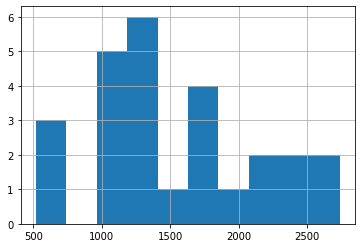

In [199]:
PH_output['waitingTimeSimulation'].dt.seconds.hist()

<AxesSubplot:>

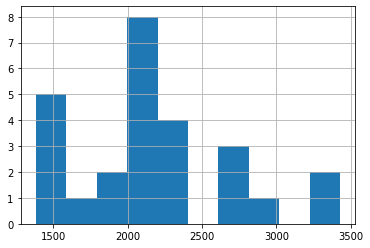

In [200]:
PH_output['waitingTimeReal'].dt.seconds.hist()

In [165]:
import GoogleDistanceMatrix
import API

GoogleDistanceMatrix.get_distance_matrix(API.key, ['22.2863114,114.1452516','22.284392699999998,114.141973'])

[[0, 286], [391, 0]]

In [1]:
import GoogleVRP

In [2]:
GoogleVRP.VRP([[0, 127, 89], [131, 0, 174], [91, 46, 0]],1,6000)

[{0: [0, 2, 1]}, {0: 266}, {0: 135}]